In [17]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
import pandas as pd

df = pd.read_csv('/content/gdrive/My Drive/digits.csv')
df.describe()

,evtId,ipad,itime,amp
count,196230.000000,196230.000000,196230.000000,196230.000000
mean,5000.826041,43.302176,270.375152,293.583113
std,2886.154585,1.144196,1.448870,1107.341668
min,0.000000,40.000000,267.000000,1.000000
25%,2503.000000,42.000000,269.000000,20.130000
50%,4999.000000,43.000000,270.000000,108.800000
75%,7499.000000,44.000000,272.000000,333.075000
max,9998.000000,46.000000,274.000000,40950.000000


In [0]:
df['ipad'] -= df.min()['ipad']
df['itime'] -= df.min()['itime']

In [0]:
import numpy as np

from scipy.sparse import csr_matrix

data = np.array(df)
data = np.array([data[data[:, 0] == k] for k in np.unique(data[:, 0])])
images = []

for i in range(0, data.shape[0]):
  row = np.array(data[i][:, 1])
  col = np.array(data[i][:, 2])
  amp = np.log(np.array(data[i][:, 3]))
  images.append(csr_matrix((amp, (row, col)), shape=(8, 8)).toarray())

images = np.expand_dims(images, axis=3)

In [22]:
%tensorflow_version 2.x

import tensorflow as tf
tf.__version__

'2.2.0'

In [23]:
from tensorflow.keras.models import load_model

generator = load_model('/content/gdrive/My Drive/generator_.h5')

In [0]:
N = 10

def draw_imgs(generated, original):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(generated.reshape((N, N, 8, 8)).transpose(0, 2, 1, 3).reshape(N * 8, N * 8))
    plt.subplot(1, 2, 2)
    plt.imshow(original.reshape((N, N, 8, 8)).transpose(0, 2, 1, 3).reshape(N * 8, N * 8))
    plt.show()

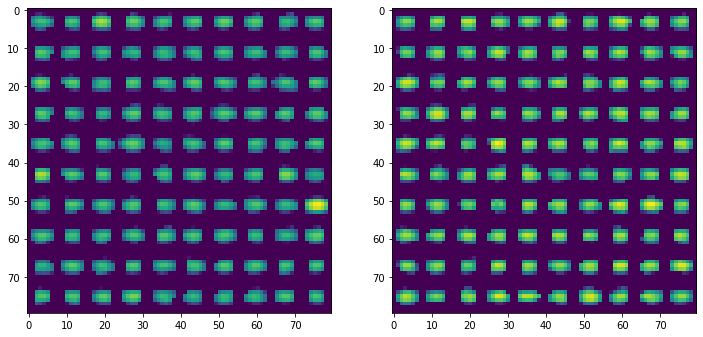

In [25]:
import matplotlib.pyplot as plt

LATENT_DIM = 32

generated_images = generator(tf.random.normal(shape=(N * N, LATENT_DIM)))
draw_imgs(images[:N * N], generated_images.numpy())

In [0]:
import math

def sample_mean(X, weights=None):
    """ X - sample x1, x2, .. xn
    X - np.array
    returns sample mean
    """
    if weights is None:
        weights = np.ones(X.shape)
    return np.sum(X * weights) / np.sum(weights)

def sample_variance(X, weights=None):
    """ X - sample x1, x2, .. xn
    X - np.array
    returns sample varience ** 2
    """
    mean = sample_mean(X, weights)
    if weights is None:
        weights = np.ones(X.shape)
    sqr_variance = np.sum(weights * ((X - mean) ** 2)) / np.sum(weights)
    return math.sqrt(sqr_variance)

def unbiased_sample_variance(X, weights=None):
    """
    https://en.wikipedia.org/wiki/Unbiased_estimation_of_standard_deviation
    """
    if weights is None:
        weights = np.ones(X.shape)
    n = np.sum(weights)
    return sample_variance(X, weights) * math.sqrt(n) / math.sqrt(n - 1)

def standard_error(X):
    return math.sqrt(unbiased_sample_variance(X)) / math.sqrt(X.shape[0])


def sample_correlation_coefficient(X, Y):
    """
    X - sample x1, x2, .. xn
    Y - sample y1, y2, .. yn
    X, Y - np.array
    https://en.wikipedia.org/wiki/Correlation_and_dependence
    """
    x_mean, y_mean = sample_mean(X), sample_mean(Y)
    return np.sum((X - x_mean) * (Y - x_mean)) / ((X.shape[0] - 1) * unbiased_sample_variance(X) * unbiased_sample_variance(Y))

In [0]:
def get_max_amplitude(img):
    return np.amax(img)

def get_mean_amplitude(img):
    return np.mean(img)

def get_center(img):
    img = img.reshape((8, 8))
    y_range = np.array(list(map(lambda x: range(0, 8), range(0, 8))))
    x_range = np.transpose(y_range)
    y_mean = sample_mean(y_range, img)
    x_mean = sample_mean(x_range, img)
    return [x_mean, y_mean]

def get_covariance(img):
    img = img.reshape((8, 8))
    y_range = np.array(list(map(lambda x: range(0, 8), range(0, 8))))
    x_range = np.transpose(y_range)
    mu0 = sample_variance(x_range, img)
    mu1 = sample_variance(y_range, img)
    [x_mean, y_mean] = get_center(img)
    cov = sample_variance((x_range - x_mean) * (y_range - y_mean), img)
    return [mu0, mu1, cov]

In [0]:
import seaborn as sns

In [0]:
from scipy.stats import ks_2samp
from matplotlib import pyplot

def get_centers(imgs):
    return np.array(list(map(lambda img: get_center(img), imgs)))

def get_amps(imgs):
    return np.array(list(map(lambda img: get_max_amplitude(img), imgs)))

def get_mean_amps(imgs):
    return np.array(list(map(lambda img: get_mean_amplitude(img), imgs)))

def get_covariances(imgs):
    return np.array(list(map(lambda img: get_covariance(img), imgs)))

def plot_centers(real, generated):
    plt.scatter(real[:, 0], real[:, 1], color='limegreen', s=1)
    plt.scatter(generated[:, 0], generated[:, 1], color='gold', s=1)
    plt.xlabel("Centers distribution\n yellow - generated\n green - original")
    plt.show()

def distplot(real, generated):
    sns.distplot(real, label='real')
    sns.distplot(generated, label='generated')
    pyplot.legend(loc='upper right')
    plt.show()

def show_mistake(real_dist, generated_dist, name=""):
    print(name)
    real_mean = sample_mean(real_dist)
    generated_mean = sample_mean(generated_dist)
    real_covariance = sample_variance(real_dist)
    ks_2samp(real_dist, generated_dist)
    generated_covariance = sample_variance(generated_dist)
    print("Real mean: ", real_mean, " ∓ ",  standard_error(real_dist))
    print("Generated mean: ", generated_mean, ", Error: ", abs(generated_mean - real_mean))
    print("Real covariance: ", real_covariance, ", Generated covariance: ", generated_covariance)
    print("Kolmogorov–Smirnov test: ", ks_2samp(real_dist, generated_dist)[0] * math.sqrt(len(real_dist) / 2), ks_2samp(real_dist, generated_dist)[1])

def plot_results(real, generated):
    real_centers = get_centers(real)
    generated_centers = get_centers(generated)

    plot_centers(real_centers, generated_centers)

    show_mistake(real_centers[:, 0], generated_centers[:, 0], "X_center")
    show_mistake(real_centers[:, 1], generated_centers[:, 1], "Y_center")

    real_amps = get_amps(real)
    generated_amps = get_amps(generated)

    distplot(real_amps, generated_amps)
    show_mistake(real_amps, generated_amps, "Amplitude")

    real_amps = get_mean_amps(real)
    generated_amps = get_mean_amps(generated)

    distplot(real_amps, generated_amps)
    show_mistake(real_amps, generated_amps, "Amplitude")

    real_cov = get_covariances(real)
    generated_cov = get_covariances(generated)

    for i in range(0, 3):
        distplot(real_cov[:, i], generated_cov[:, i])
        show_mistake(real_cov[:, i], generated_cov[:, i], "Covariance")



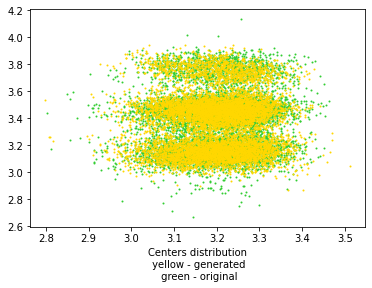

X_center
Real mean:  3.199911927438748  ∓  0.003112588091989475
Generated mean:  3.19799223284264 , Error:  0.0019196945961081902
Real covariance:  0.08718899743667106 , Generated covariance:  0.08681372379595705
Kolmogorov–Smirnov test:  0.9018807509249152 0.39015666905462154
Y_center
Real mean:  3.3720812023407913  ∓  0.004957806714730168
Generated mean:  3.3741470827210804 , Error:  0.002065880380289098
Real covariance:  0.22120633652049587 , Generated covariance:  0.21690569928130632
Kolmogorov–Smirnov test:  0.6931810730249348 0.7225849733680535


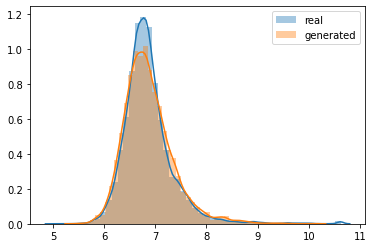

Amplitude
Real mean:  6.86340579153235  ∓  0.007410691858724727
Generated mean:  6.868299127048917 , Error:  0.004893335516566566
Real covariance:  0.4942377244850107 , Generated covariance:  0.4883604405679593
Kolmogorov–Smirnov test:  2.854713451274731 1.662709190132916e-07


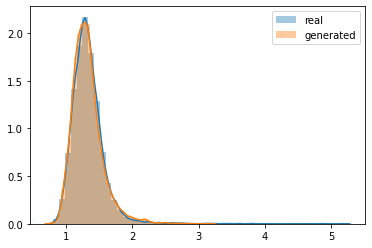

Amplitude
Real mean:  1.328397064716942  ∓  0.005217225580401452
Generated mean:  1.3211140428450372 , Error:  0.007283021871904882
Real covariance:  0.24496137471171017 , Generated covariance:  0.23125112938270462
Kolmogorov–Smirnov test:  1.945379140424817 0.0010317556256666457


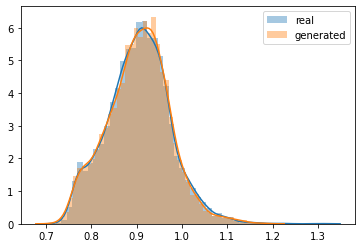

Covariance
Real mean:  0.9042555637417461  ∓  0.002785408266913948
Generated mean:  0.9035992057474398 , Error:  0.0006563579943063003
Real covariance:  0.06982261356316344 , Generated covariance:  0.06932493432427123
Kolmogorov–Smirnov test:  0.6708203932499369 0.7591280239983434


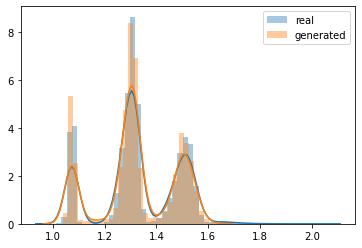

Covariance
Real mean:  1.3301123896425666  ∓  0.004116913718540873
Generated mean:  1.3254143868592105 , Error:  0.004698002783356081
Real covariance:  0.15253233236849184 , Generated covariance:  0.14783652153533658
Kolmogorov–Smirnov test:  1.647236743424845 0.008792338034759421


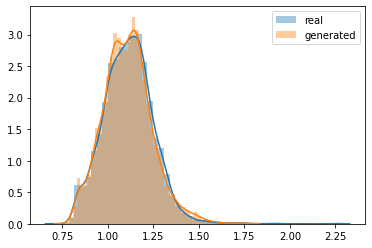

Covariance
Real mean:  1.1140093732704683  ∓  0.003882378411978637
Generated mean:  1.1101048922849288 , Error:  0.003904480985539527
Real covariance:  0.13564822256375603 , Generated covariance:  0.134789573390853
Kolmogorov–Smirnov test:  1.9602862602748155 0.00091832029964147


In [30]:
real = images[:9000]
generated = generator(tf.random.normal(shape=(9000, LATENT_DIM))).numpy()

plot_results(real, generated)

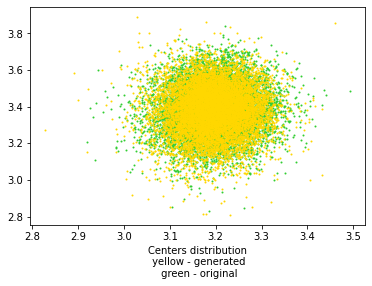

X_center
Real mean:  3.194630601766769  ∓  0.002498030228867415
Generated mean:  3.1947857828449693 , Error:  0.00015518107820033933
Real covariance:  0.062392189932803765 , Generated covariance:  0.060856037134576275
Kolmogorov–Smirnov test:  0.7849277744870009 0.5688718689045942
Y_center
Real mean:  3.3846649658285326  ∓  0.0035377939573703653
Generated mean:  3.38217650721218 , Error:  0.0024884586163524958
Real covariance:  0.12514108671246216 , Generated covariance:  0.1275646731245604
Kolmogorov–Smirnov test:  1.2869986933030106 0.07282838103543107


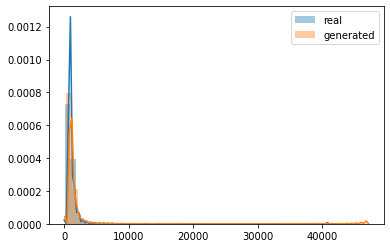

Amplitude
Real mean:  1189.655395539554  ∓  0.4599473286203407
Generated mean:  1129.5629194969058 , Error:  60.092476042648286
Real covariance:  2115.1981210874287 , Generated covariance:  1127.1003590022085
Kolmogorov–Smirnov test:  3.1114254123809046 7.761630108862e-09


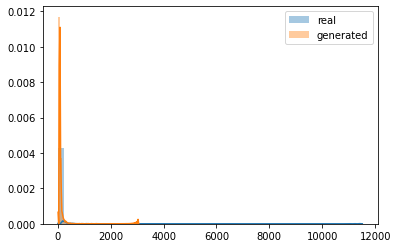

Amplitude
Real mean:  90.71769707439493  ∓  0.15909833535054796
Generated mean:  81.364479820327 , Error:  9.353217254067928
Real covariance:  253.0848343762362 , Generated covariance:  81.58153761961327
Kolmogorov–Smirnov test:  2.0365693608311375 0.0004990447814652144


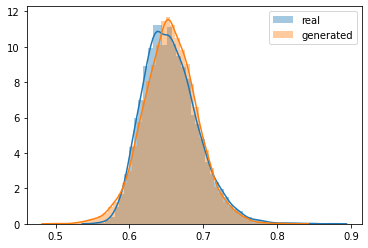

Covariance
Real mean:  0.6556814893528434  ∓  0.0019208825172514377
Generated mean:  0.655288418142234 , Error:  0.0003930712106093859
Real covariance:  0.03689236172022529 , Generated covariance:  0.03667115316890841
Kolmogorov–Smirnov test:  2.892211349235886 1.0807321764572012e-07


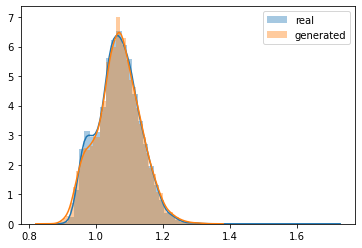

Covariance
Real mean:  1.0657803424900032  ∓  0.002531726243514138
Generated mean:  1.066252522026279 , Error:  0.00047217953627587406
Real covariance:  0.06408676318419142 , Generated covariance:  0.06615530211959286
Kolmogorov–Smirnov test:  1.1809273724263887 0.12291602320514398


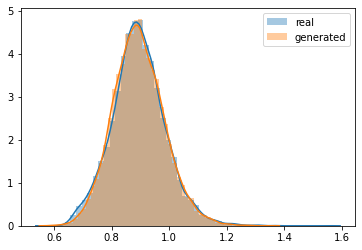

Covariance
Real mean:  0.8934538393216598  ∓  0.0030490151121405308
Generated mean:  0.8936655671542755 , Error:  0.0002117278326156935
Real covariance:  0.09295098668465865 , Generated covariance:  0.089158378713743
Kolmogorov–Smirnov test:  1.0960703157250913 0.18080989326992605


In [31]:
real = np.exp(images[:9999])
generated = np.exp(generator(tf.random.normal(shape=(9999, LATENT_DIM))).numpy())
plot_results(real, generated)